- Note that the Elasticsearch should be running on your computer. The simplest option is using Docker:

docker run -d -p 9200:9200 -e "discovery.type=single-node" elasticsearch:7.9.2

In [1]:
!curl -X GET "localhost:9200/"

{

  "name" : "8202d20318fa",

  "cluster_name" : "docker-cluster",

  "cluster_uuid" : "9Uw7ztzPTnyT-3HMKW1SbQ",

  "version" : {

    "number" : "7.9.2",

    "build_flavor" : "default",

    "build_type" : "docker",

    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",

    "build_date" : "2020-09-23T00:45:33.626720Z",

    "build_snapshot" : false,

    "lucene_version" : "8.6.2",

    "minimum_wire_compatibility_version" : "6.8.0",

    "minimum_index_compatibility_version" : "6.0.0-beta1"

  },

  "tagline" : "You Know, for Search"

}


# Initializing Document Store
- First, iterate through all unique documents and write them to the database
- Finally, test whether the document store is able to retrieve the stored document

In [2]:
from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore
document_store = ElasticsearchDocumentStore(return_embedding=True)

In [3]:
from datasets import load_dataset
dataset = load_dataset("csv", data_files=["electronics/splits/train.csv", "electronics/splits/test.csv", \
                                         "electronics/splits/dev.csv"])["train"]
dataset = dataset.train_test_split(test_size=0.1)

Found cached dataset csv (/home/matoanderson/.cache/huggingface/datasets/csv/default-92c4c30cf6fed825/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
dfs = {split: dset.to_pandas() for split, dset in dataset.flatten().items()} #store each split as separate DF

In [5]:
for split, df in dfs.items():
    docs=[{"content": row["review"], "id": row["review_id"], "meta":{"item_id": row["item_id"], \
        "question_id": row["q_review_id"], "split": split}} \
         for _, row in df.drop_duplicates(subset="review_id").iterrows()]
    document_store.write_documents(documents=docs, index="document")

In [6]:
from haystack.nodes.retriever import BM25Retriever
bm25_retriever = BM25Retriever(document_store=document_store)

In [7]:
query = dataset["test"][0]["question"]
retrieved_docs = bm25_retriever.retrieve(query=query, top_k=3, filters={"split":["test"]})
print(retrieved_docs[0])
print(f"Actual id is: {dataset['train'][0]['review_id']}")

<Document: id=6fb77323e8e26fd43cfede356ab3d897, content='We were trying to live simply and watch less television. We also wanted to save some money by discon...'>

Actual id is: 190d44e2ee2a0b2053377b6be26eda53


# Simple Pipeline
- First, initialize the reader and the pipeline
- Next, make a simple prediction

In [8]:
from haystack.nodes import FARMReader
from transformers import AutoModelForQuestionAnswering, AutoTokenizer
model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False, \
                   max_seq_len=max_seq_length, doc_stride=doc_stride, return_no_answer=True)

/home/matoanderson/.local/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

  return self.fget.__get__(instance, owner)()


In [9]:
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(reader=reader, retriever=bm25_retriever)

In [10]:
n_answers = 3
preds = pipe.run(query=query, params={"Retriever": {"top_k": 3, "filters":{"split":["train"]}}, \
                                      "Reader":{"top_k": n_answers}})

In [11]:
print(f"Question: {preds['query']}\n")
for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx].answer}")
    print(f"Review snippter: ...{preds['answers'][idx].context}...")
    print("\n")

Question: How is the quality of the return policy?



Answer 1: good

Review snippter: ...I got a rare bad one but amazon's return policy is good so no problem except of course having to wait for another one. ANSWERNOTFOUND...





Answer 2: 

Review snippter: ...None...





Answer 3: how small it was.  That's a good thing, the picture somehow makes the product look much bigger

Review snippter: ... days later I was struck by how small it was.  That's a good thing, the picture somehow makes the product look much bigger.The installation could not ...






# Baseline Evaluation

- Create a list of label objects for the document store for later evaluation
- Initiate a pipeline for the retriever only (since both components should be evaluated separately)
- Initiate another pipeline to evaluate the reader

In [12]:
from haystack import Label, Answer, Document
labels = []
for i, row in dfs["test"].iterrows(): 
    meta = {"item_id":  row["item_id"], "question_id": row["q_review_id"]}
    if row["human_ans_spans"] != "ANSWERNOTFOUND": #not an empty answer
        label = Label(query=row["question"], answer=Answer(answer=row["human_ans_spans"]), origin="gold-label", \
                  document=Document(content=row["review"], id=row["review_id"]),
                  is_correct_answer=True, is_correct_document=True, no_answer=False, \
                  filters={"item_id": [meta["item_id"]], "split":["test"]})
        labels.append(label)
    else:
        label = Label(query=row["question"], answer=Answer(answer=""), origin="gold-label", \
                     document=Document(content=row["review"], id=row["review_id"]), meta=meta, \
                     is_correct_answer=True, is_correct_document=True, no_answer=True, \
                     filters={"item_id": [row["item_id"]], split:"test"})
        labels.append(label)
document_store.write_labels(labels, index="label") 
labels = document_store.get_all_labels_aggregated(index="label", open_domain=True, aggregate_by_meta=["item_id"])

In [13]:
from haystack.pipelines import DocumentSearchPipeline
pipe = DocumentSearchPipeline(retriever=bm25_retriever)

In [14]:
eval_result = pipe.eval(labels=labels, params={"Retriever": {"top_k": 3}})
metrics = eval_result.calculate_metrics()
print(f"Recall for Retriver: {metrics['Retriever']['recall_single_hit']:.2f}") 

Recall for Retriver: 0.67


In [15]:
from haystack.pipelines import Pipeline
def evaluate_reader(reader):
    score_keys = ["exact_match", "f1"]
    p = Pipeline()
    p.add_node(component=reader, name="Reader", inputs=["Query"])
    eval_result = p.eval(labels=labels, documents=[[label.document for label in multilabel.labels] \
                                                  for multilabel in labels], params={})
    metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
    return {k:v for k,v in metrics["Reader"].items() if k in score_keys}
reader_eval = {}
reader_eval["fine-tuned on SQuAD"] = evaluate_reader(reader)

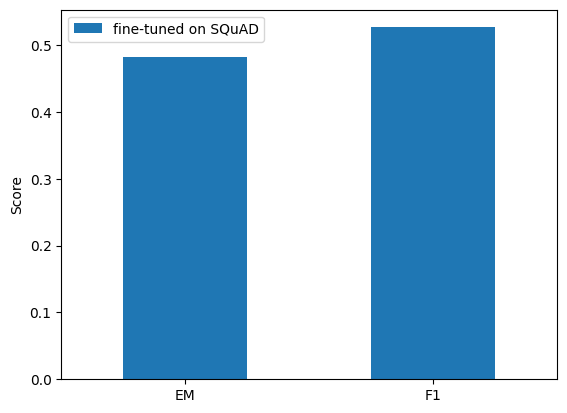

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval)
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc="upper left")
    plt.show()
plot_reader_eval(reader_eval)
    

# Dense Passage Retrieval
- Using two BERT models as encoders for the question and passage. The dot product similarity between the two vectors will result in the new document score
- Update the embeddings and run the evaluation again

In [17]:
from haystack.nodes import DensePassageRetriever
dpr_retriever = DensePassageRetriever(document_store=document_store, \
                                     query_embedding_model="facebook/dpr-question_encoder-single-nq-base", \
                                     passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base", \
                                     embed_title=False)

/home/matoanderson/.local/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

  return self.fget.__get__(instance, owner)()

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 

The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 

The class this function is called from is 'DPRContextEncoderTokenizerFast'.


In [18]:
document_store.update_embeddings(retriever=dpr_retriever)
pipe = DocumentSearchPipeline(retriever=dpr_retriever)
eval_result = pipe.eval(labels=labels, params={"Retriever": {"top_k":3}})
metrics = eval_result.calculate_metrics()
print(f"Recall for Retriever: {metrics['Retriever']['recall_single_hit']:.2f}")

Updating embeddings:   0%|          | 0/1615 [00:00<?, ? Docs/s]

Create embeddings:   0%|          | 0/1616 [00:00<?, ? Docs/s]

Recall for Retriever: 0.67


- Did not improve the retriever, but still the default choice for embeddings 

# Fine-Tuning the Reader
- Training the reader requires an additional, yet important, step: converting the data into SQuAD JSON format

In [19]:
def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df["review_id"], df["review"]))
    for document_id, document in id2context.items():
        qas = []
        document_df = df.query(f"review_id == '{document_id}'")
        id2question = dict(zip(document_df["q_review_id"], document_df["question"]))
        for qid, question in id2question.items():
            question_df = document_df.query(f"q_review_id == '{qid}'").to_dict(orient="list")
            ans_start_idx = [i.find(",") for i in question_df["human_ans_indices"]] #"(start, end)"
            ans_start = [int(j[1:ans_start_idx[i]]) for i,j in enumerate(question_df["human_ans_indices"])]
            ans_text = question_df["human_ans_spans"]
            
            answers = [{"text": text, "answer_start": start} for text, start in zip(ans_text, ans_start) \
                          if text != "ANSWERNOTFOUND"]
            is_impossible = False
            if not answers: #no valid answers
                is_impossible = True
            qas.append({"question": question, "id": qid, "is_impossible": is_impossible, "answers": answers})
        paragraphs.append({"qas": qas, "context": document})
    return paragraphs

In [20]:
import json
def convert_to_squad(dfs):
    for split, df in dfs.items():
        qa_data = {}
        paragraphs = df.groupby("item_id").apply(create_paragraphs).to_frame(name="paragraphs").reset_index()
        qa_data["data"] = paragraphs.to_dict(orient="records")
        with open(f"qa-{split}.json", "w+", encoding="utf-8") as f:
            json.dump(qa_data, f)
convert_to_squad(dfs)

In [21]:
%%capture
#produces a lot of output, mostly about some samples that cannot be used because the provided answer does not directly appear in the context
train = "qa-train.json"
dev = "qa-test.json"
reader.train(data_dir=".", use_gpu=True, n_epochs=5, batch_size=4, train_filename=train, dev_filename=dev)

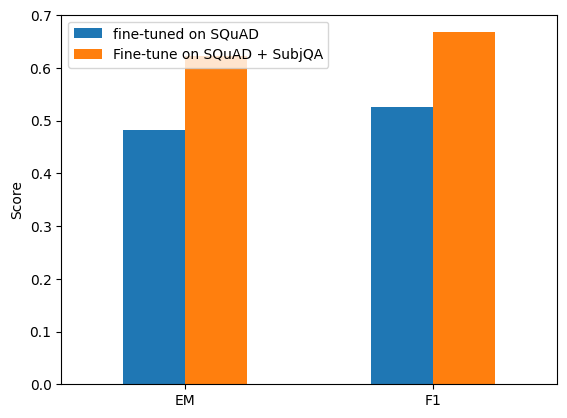

In [22]:
reader_eval["Fine-tune on SQuAD + SubjQA"] = evaluate_reader(reader)
plot_reader_eval(reader_eval)

- Training definitely increases both scores

# Inference
- The same query as before. This time with much more accurate replies

In [23]:
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(reader=reader, retriever=bm25_retriever)
n_answers = 3
preds = pipe.run(query=query, params={"Retriever": {"top_k": 3, "filters":{"split":["train"]}}, \
                                      "Reader":{"top_k": n_answers}})
print(f"Question: {preds['query']}\n")
for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx].answer}")
    print(f"Review snippter: ...{preds['answers'][idx].context}...")
    print("\n")

Question: How is the quality of the return policy?



Answer 1: amazon's return policy is good

Review snippter: ...I got a rare bad one but amazon's return policy is good so no problem except of course having to wait for another one. ANSWERNOTFOUND...





Answer 2: 

Review snippter: ...None...





Answer 3: Amazons great return policy

Review snippter: ...aw one with no glare to read. So we thought for the price and Amazons great return policy why not try the new HD out and see how it is for reading.OH ...




